<a href="https://colab.research.google.com/github/eurashin/CS282_MDP_Game_Recourse/blob/master/Final%20-%20Recourse_for_Agents_in_MDP_Game_Frameworks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recourse for Agents in MDP Game Frameworks
---
Authors: Anna J. Li, Eura Shin, Ruby Zhang

## Implementation
---
Our solution has 3 main modules:

1. **Agent Policy Inference:** Given the agent's trajectory, we infer their policy/value function using Inverse Reinforcement Learning (IRL)

2. **Improved Policy Search:** Once we obtain the estimated agent's suboptimal policy, we find an improved policy under the constrained MDP framework using a modified form of Q-learning.

3. **Evaluation Generation:** We obtain an improved policy and use that policy to explain a general strategy that will improve the user's outcome.

## RL Environment
[Tutorial](https://www.learndatasci.com/tutorials/reinforcement-q-learning-scratch-python-openai-gym/)

In [215]:
import numpy as np
import gym
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import copy
import seaborn as sns

rl_env = gym.make("Taxi-v3").env # Initializing the RL environment THIS SHOULD ONLY BE DONE ONCE (since the RL environment for the IRL and the recourse should be the same)
rl_env.render() # Show how the RL environment looks

# SEED EVERYTHING
# https://towardsdatascience.com/stop-using-numpy-random-seed-581a9972805f
RANDOM_SEED = 123
np.random.seed(RANDOM_SEED)
rl_env.seed(RANDOM_SEED)
rl_env.action_space.seed(RANDOM_SEED)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



[123]

In [247]:
num_rows = 5 # encodes taxi's row
num_cols = 5 # encodes taxi's column
num_passenger_locations = 5 # where passenger is located
num_destinations = 4 # where destination location

class TaxiQLearner:
  def __init__(self, env, epsilon = 0.1, gamma = 0.5, alpha = 0.6):
    self.env = env
    # Initialize Q-table
    self.num_states = num_rows * num_cols * num_passenger_locations * num_destinations
    self.num_actions = 6 # 6 actions: south, north, east, west, pickup passenger, dropoff passenger
    self.Q = np.zeros((self.num_states, self.num_actions)) # states x actions

    # Initialize learning parametesr
    self.epsilon = epsilon # e-greedy
    self.gamma = gamma # discount rate
    self.alpha = alpha # step size

  def policy(self, state): 
      # E-greedy 
      rand = np.random.uniform(0, 1)
      if np.sum(self.Q[state, :]) == 0 or rand <= self.epsilon: #random
        action = self.env.action_space.sample()
      else: # greedy
        max_actions = np.argwhere(self.Q[state,:] == np.amax(self.Q[state,:])).flatten()
        action = np.random.choice(max_actions)
      return action

  # reset agent
  def reset(self):
    self.Q = np.zeros((self.num_states, self.num_actions)) # states x actions    
  
  def train(self, num_episodes, user_Q = None, sparse_penalty = None):
    data = []
    rewards = []
    episode_size = []
    for episode in range(num_episodes):
        D, r = self.run_episode(user_Q = user_Q, sparse_penalty = sparse_penalty)
        self.alpha = max(self.alpha - (1e-2 * self.alpha), 1e-3)
        data.append(D)
        rewards.append(r)
        episode_size.append(D.shape[0])
        # Callback
        if episode % 25 == 0: 
          print("Episode {} latest length {}".format(episode, D.shape[0]))
    return np.vstack(data), np.array(rewards), np.array(episode_size)

    
  # Runs the TaxiV3 environment for the specified number of episodes WITHOUT changing the agent's Q-table
  # Returns: each of the following array are length n, where n is the number of episodes: 
  #        * total_steps: the number of steps the agent took during each episode
  #        * total_penalties: the number of penalties (illegal moves) agent made durinig the episode
  #        * total_rewards: the number 
  def evaluate(self, num_episodes):
    total_steps = np.zeros(num_episodes)
    total_penalties = np.zeros(num_episodes)
    total_rewards = np.zeros(num_episodes)
    for i in range(num_episodes): # run an episode
      state = self.env.reset() # start a new episode
      done = False
      steps = 0
      penalties = 0
      rewards = 0
      while not done: 
        # Perform action
        action = self.policy(state)
        next_state, reward, done, info = self.env.step(action)
        # Track data
        if reward == -10: 
          penalties += 1
        rewards += reward
        steps += 1
        state = next_state

        total_steps[i] = steps
        total_penalties[i] = penalties
        total_rewards[i] = rewards
      if i%25 == 0:  
        print("Evaluation episode {}: {} steps".format(i, steps))
        
    return total_steps, total_penalties, total_rewards


  # Runs a single episode of TaxiV3. The passenger pickup and dropoff locations are randomized at the beginning of the episode. 
  # If train = True, then the agent's Q-table will be updated based on the results of this episode. 
  # Returns: a numpy array of (state, action, reward, next state) tuples and the cumulative rewards for the episode
  # If user_Q is given then we will assume the sparse Q-learning step
  def run_episode(self, train = True, user_Q = None, sparse_penalty = None): 
    curr_state = self.env.reset() # start a new episode
    curr_action = self.policy(curr_state)

    done = False
    D = [] # data of trajectory
    total_rewards = 0
    while not done: 
      # Perform action
      next_state, reward, done, info = self.env.step(curr_action)
      # Track data
      total_rewards += reward
      experience = list(self.env.decode(curr_state)) # s
      experience.extend([curr_state]) # encoded current state
      experience.extend([curr_action]) # a
      experience.extend([reward]) # r
      experience.extend(list(self.env.decode(next_state))) # s'
      experience.extend([next_state]) # encoded next state
      D.append(experience) 

      # Get next action
      next_action = self.policy(next_state)

      # Update Q-values
      if train: 
        if user_Q is None: # Normal update
            self.Q[curr_state, curr_action] = self.Q[curr_state, curr_action] + self.alpha * ((reward + self.gamma * self.Q[next_state, next_action]) - self.Q[curr_state, curr_action])
        else: 
            user_action = np.argmax(user_Q[curr_state, :])
            if user_action != curr_action: # penalty
                self.Q[curr_state, curr_action] = self.Q[curr_state, curr_action] + self.alpha * ((reward  - sparse_penalty + self.gamma * self.Q[next_state, next_action]) - self.Q[curr_state, curr_action])
            else: 
                self.Q[curr_state, curr_action] = self.Q[curr_state, curr_action] + self.alpha * ((reward + self.gamma * self.Q[next_state, next_action]) - self.Q[curr_state, curr_action])

      curr_state = copy.deepcopy(next_state)
      curr_action = copy.deepcopy(next_action)


    return np.array(D), total_rewards

  def render(self):
    self.env.render()


## 1. Agent Policy Inference (Inverse Reinforcement Learning)
---

### Helper Functions
---

In [237]:
class max_entropy:
  def __init__(self, trajectories, epochs, learning_rate, epsilon, environment, minibatch_size = 100, 
               state_features = ['taxi_row', 'taxi_column', 'passenger_loc', 'destination']):
    # agent trajectory and state feature names
    self.trajectories = trajectories
    self.state_features = state_features
    # open ai environment, so later we can encode and decode state and have access to transition probabilities
    self.env = environment 
    # gradient descent parameters
    self.epochs = epochs 
    self.learning_rate = learning_rate
    self.gd_threshold = epsilon # stopping criterion
    self.verbose = True 
    self.minibatch_size = minibatch_size

    # get terminal states for the taxi open ai
    self.terminal_state = set()
    for trajectory in self.trajectories:
      # the last state where passenger location = destination location
      self.terminal_state.add(trajectory.loc[trajectory.shape[0] - 1, 'new_state']) 

    # Encode trajectories
    self.phi_trajectories = []
    for trajectory in self.trajectories: 
      phi_traj = self.encode_trajectory(trajectory)
      self.phi_trajectories.append(phi_traj)

    # Get transition matrix
    self.P = np.zeros((self.env.nS, self.env.nA, self.env.nS))
    for state in range(self.env.nS):
      for action in range(self.env.nA):
        next_state = self.env.P[state][action][0][1]
        self.P[state, action, next_state] = 1

  # part 1 of the gradient: empirical expected feature counts from M trajectories
  '''
  def expected_feature_count(self):
    
      #return: a (4, ) vector for expected feature count ['taxi_row', 'taxi_column', 'passenger_loc', 'destination']
    
    efc = np.zeros(len(self.state_features)) # initialize an array
    for trajectory in self.trajectories: # for each trajectory
      # calculate sum for each feature
      for i in range(len(self.state_features)):
        feature_name = 'prev_'+ self.state_features[i] # get feature name in the data frame
        efc[i] += trajectory.loc[:, feature_name].sum()
    # take an average over # of trajectories
    return efc / len(self.trajectories)
  '''

  def expected_feature_count(self):
    '''
      return: a (4, ) vector for expected feature count ['taxi_row', 'taxi_column', 'passenger_loc', 'destination']
    '''
    efc = np.zeros((500, 1)) # initialize an array
    traj_i = np.random.choice(range(len(self.trajectories)), self.minibatch_size) # minibatch of trajectory
    batch_trajectories = []
    for i in traj_i: # for each trajectory
      trajectory = self.phi_trajectories[i]
      batch_trajectories.append(self.trajectories[i])
      efc += trajectory

    # take an average over # of trajectories
    return efc / self.minibatch_size, batch_trajectories

  # get probabilities for each state being the initial state
  def s0_probabilities(self):
    '''
      return p_s0 as a (500, ) array
    '''
    p_s0 = np.zeros(self.env.nS)
    # accumulate over initial state s0 for each trajectory
    for trajectory in self.trajectories:
      s0 = trajectory.loc[0, 'prev_state'] # initial state = prev-state in the first row
      # count # times each state being s0
      p_s0[s0] += 1.0
    return p_s0 / len(self.trajectories) # average by # of trajectories -> sum to be 1

  '''
  def deal_with_overflow(self, input):
    if not np.isfinite(input).all():
      finite_values = np.where(np.isfinite(input), input, 1e-6)
      max_value, min_value = finite_values.max(), finite_values.min()
      
      new_input = np.where(np.isposinf(input), max_value, input)
      new_input = np.where(np.isneginf(new_input), min_value, new_input)
      new_input = np.where(np.isnan(new_input), min_value, new_input)  
      return new_input
    else:
      return input
    '''

  def expected_state_visitation_frequency(self, user_reward, batch_trajectories):
    '''
      input:
        user_reward: per-state reward we learn during the optimization
      return p_state_frequency (num_state(500), ) array
    '''
    num_state = self.env.nS
    num_actions = self.env.nA
    print("Backward pass...")
    # backward pass
    # initialize the state partition function at terminal states
    state_partition = np.zeros(num_state, dtype=np.float64)
    state_partition[list(self.terminal_state)] = 1

    # recursively learn the state action and state partition functions
    for i in range(100): # Usually 2 * number of states 
        # initialize the state action partition function
      state_action_partition = np.zeros((num_state, num_actions), dtype=np.float64)

      # for each state action pair, update the parition function
      for prev_state in range(num_state):
        for action in range(num_actions):
          # since we have deterministic MDP, there is only one unique new_state
          new_state = self.env.P[prev_state][action][0][1]
          reward = user_reward[prev_state]
          # avoid overflow: exp(a - b) = exp(a) / exp(b)
          max_reward = user_reward.max()
          if max_reward > 1: 
            state_action_partition[prev_state, action] = 1.0 * reward/max_reward * state_partition[new_state]
          else: 
            state_action_partition[prev_state, action] = 1.0 * reward * state_partition[new_state]
    
      # update the state partition function
      state_partition = state_action_partition.sum(axis = 1) # over different actions


    # get local action probability
    # p_action = state_action_partition / corresponding state_partition
    p_action = state_action_partition / (state_partition.reshape((-1, 1)) + 1e-5)
    #p_action = self.deal_with_overflow(p_action)

    # forward pass
    # initialize D_s_t with d0 probabilities
    T = max([t.shape[0] for t in batch_trajectories])
    D = np.zeros((num_state, T)) # get T = max length of trajectories
    D[:, 0] = self.s0_probabilities()

    print("Forward pass...")
    # iterate over T steps
    for t in range(1, T):
      if t % 100 == 0: 
        print("{}/{}".format(t, T))
      # Update D_s, t
      for s_to in range(num_state):
        # Get all states that could lead to current
        transition_to = self.P[:, :, s_to]
        state_action_froms = np.where(transition_to == 1) # states, actions that lead to s_to
        s_from_values = 0
        for i in range(state_action_froms[0].shape[0]):
          s_from_values += D[state_action_froms[0][i], t-1] * p_action[state_action_froms[0][i], state_action_froms[1][i]]
        
        D[s_to, t] += np.sum(s_from_values)
    
    # sum over different t
    D_return = D.sum(axis = 1).reshape(-1, 1)
    print("Done: ", D_return.shape)
    #D_return = self.deal_with_overflow(D_return)
    return D_return

  def encode_trajectory(self, trajectory):
    # returns one-hot encoded trajectory
    phi_traj = np.zeros((500, 1))
    states, counts = np.unique(trajectory.loc[:, 'prev_state'], return_counts=True) 
    phi_traj[states] = counts.reshape(-1, 1)
    phi_traj[trajectory.iloc[-1, -1]] += 1
    return phi_traj


  # maximum entropy IRL
  def max_entropy_irl(self, feature_map):
    '''
    input:
      feature map: (num_state x num_features) array to get features for each state
    '''
    # initialize reward weight
    reward_weight = np.random.uniform(size = (feature_map.shape[1],1))

    # compute part 1 of the gradient: empirical expected feature count
    # gradient descent optimization
    grads = [] # plot gradients
    reward_diff = self.gd_threshold + 1 # keep track of the difference between current reward and the last reward

    # stop when reach num of epochs or changes in reward < threshold
    for i in range(self.epochs):
      print("Iteration {}".format(i))
      f_delta, batch_trajectories = self.expected_feature_count()
      print(f_delta[:10, 0])

      # per-state reward
      user_reward = feature_map.dot(reward_weight) 
      #print("reward: ",np.max(user_reward))
      # check for reward convergence
      if i > 0:
        reward_diff = np.max(abs(user_reward - last_reward))
      if reward_diff <= self.gd_threshold and i > 0:
        break # reward converge
      else:
        # compute gradient
        state_visitation_frequency = self.expected_state_visitation_frequency(user_reward, batch_trajectories) # part 2 of gradient
        #state_visitation_frequency = self.expected_state_visitation_frequency_deterministic(reward_weight)
        
        # normalize expected svf to sum to 1
        norm_expected_svf = state_visitation_frequency / state_visitation_frequency.sum()
        grad = f_delta -feature_map.dot(norm_expected_svf)
        grads.append(np.abs(grad).sum())
        # change reward_weight
        reward_weight += self.learning_rate * grad

        # keep a copy of the old reward
        last_reward = user_reward.copy()

      print("gradient mag: ", np.linalg.norm(grad), " reward diff: ", reward_diff)
      #if i % 10 == 0:
      #  print('finished: {}'.format(i))
      #  if self.verbose:
      #    print("gradient mag: ", np.linalg.norm(grad), " reward diff: ", reward_diff)

    # return the reward and gradients
    user_reward = feature_map.dot(reward_weight)

    return user_reward, grads

### Generating Trajectories
---

In [238]:
# Initialize the User's Policy
user_agent = TaxiQLearner(rl_env)
user_agent.epsilon = 0.1 
train_data, train_rewards, train_lengths = user_agent.train(1000) 

# Needs to be suboptimal, so randomly change the Q
random_states = np.random.choice(range(500), 50, replace = False)
user_agent.Q[random_states, :] = np.zeros((random_states.shape[0], 6))
random_action = np.random.choice(range(0, 6), random_states.shape[0], replace = True)
for i, ind in enumerate(random_action): 
    user_agent.Q[random_states[i], ind] = 1

Episode 0 latest length 454
Episode 25 latest length 285
Episode 50 latest length 93
Episode 75 latest length 27


KeyboardInterrupt: ignored

In [ ]:
# Generate trajectory data
user_data = []
for episode in range(500): # This is the number of trajectories you want
    if episode % 100 == 0: 
        print(episode)
    D, r = user_agent.run_episode(train = False)
    user_data.append(D)
        
user_trajectories = []
for data in user_data: 
    df = pd.DataFrame(data, columns = [
      'prev_taxi_row', 
      'prev_taxi_column',
      'prev_passenger_loc',
      'prev_destination',
      'prev_state',
      'action',
      'reward', # this is the true environment rewards
      'new_taxi_row', 
      'new_taxi_column',
      'new_passenger_loc',
      'new_destination',
      'new_state'])
    user_trajectories.append(df)
    
# The ground truth Q
user_ground_truth_Q = np.copy(user_agent.Q)

### Inferring the User's Policy
---

In [ ]:
me = max_entropy(trajectories = user_trajectories, epochs = 10, learning_rate = 0.001, epsilon = 0., environment = rl_env, minibatch_size = 100)

# create feature map
feature_map = np.eye(500) # One hot encoding of the state vector

# Perform IRL
user_reward, grads = me.max_entropy_irl(feature_map)

### Evaluation: Did we learn a decent approximation of the user's behavior policy?

In [ ]:
num_trials = 1
random_Q_results = np.zeros(num_trials)
learned_Q_results = np.zeros(num_trials)

for j in range(num_trials): 
    print("Trial {}".format(j))
    user_env = UserTaxiEnvironment(user_reward, rl_env, multiplier= 1.) # Define a user environment
    learned_user_agent = TaxiQLearner(user_env, epsilon = 0.4)
    _ = learned_user_agent.train(1000)
    
    # Random Q matrix
    random_Q = np.zeros((500, 6))
    random_actions = (np.random.choice(range(6), 500))
    for i, action in enumerate(random_actions):
        random_Q[i, action] = 1


    learned_Q_results[j] = compare_Q_matrices(learned_user_agent.Q, user_agent.Q)
    random_Q_results[j] = compare_Q_matrices(random_Q, user_agent.Q)

In [ ]:
# Show the action-selection similarilty scores
data = np.vstack((learned_Q_results, random_Q_results)).T
results_df = pd.DataFrame(data = data, columns = ['Learned user Q', 'Random user Q'])
sns.boxplot(data = results_df)
plt.ylabel("No. actions matching true Q")
plt.savefig('random_learned_boxplots.png')

# Visualize the Q-matrices
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

sns.heatmap(user_agent.Q[:50, :], ax=ax[0])
sns.heatmap(learned_user_agent.Q[:50, :], ax=ax[1])
sns.heatmap(random_Q[:50, :], ax=ax[2])

ax[0].set_title("User's ground truth Q")
ax[1].set_title("IRL learned Q")
ax[2].set_title("Randomly generated Q")
plt.savefig('Learned_Q_matrices.png')

In [ ]:
# learned user agent Q using the IRL user reward
user_Q = learned_user_agent.Q.copy()

# evaluate the user_agent with user_Q in the original environment
user_agent = TaxiQLearner(rl_env, epsilon = 0.3)
user_agent.Q = user_Q

# get the expected return for the user agent
user_avg_steps = simulate_episodes(user_agent, 100)

## 2. Policy Improvement
---

### Generating User's Sub-optimal Policy Trajectories
---

In [156]:
## We train a poor preforming agent
user_agent = TaxiQLearner(rl_env)
user_agent.epsilon = 0.3 # We can adjust this to be lower if you want
train_data, train_rewards, train_lengths = user_agent.train(100) # train the agent for 10 episodes (policy should be suboptimal)

Episode 0 latest length 1053
Episode 25 latest length 2518
Episode 50 latest length 96
Episode 75 latest length 1104


### Implementing Policy Improvement Algorithm
---
We assume $\lambda \in \mathbb{R}$ is a fixed constant. We modify the Q learning algorithm to encourage sparsity of changes between the original policy and the improved policy.

Using the difference of the policies, we generate user counterfactuals.

In [243]:
# penalty is a penalty function that takes in state and action
# currently this is only a sparse learner
# TODO: add in actionable functionality
def sparse_Q_learner(user_agent, reward, penalty):
  # set random seed for reproducibility
  np.random.seed(RANDOM_SEED)
  rl_env.seed(RANDOM_SEED)
  rl_env.action_space.seed(RANDOM_SEED)
  # copy
  user_agent_Q = user_agent.Q.copy()

  improved_agent = TaxiQLearner(rl_env)
  improved_agent.Q = user_agent_Q.copy()
  improved_agent.epsilon = 0.3
    
  # Train and evaluate
  current_return = reward + 1
  i = 0 
  while current_return > reward and i < 25: 
    print("Iteration {}".format(i))
    train_data, train_rewards, train_lengths = improved_agent.train(50, user_Q = user_agent_Q, sparse_penalty = penalty) 
    print("Evaluating Current New Policy")
    total_steps, _, _ = improved_agent.evaluate(100)
    current_return = np.median(total_steps)
    print("Current Return: {}".format(current_return))
    i += 1
  return improved_agent, current_return

In [244]:
def max_action_using_Q(Q, state):
  max_actions = np.argwhere(Q[state,:] == np.amax(Q[state,:])).flatten()
  return max_actions

def compute_policy_difference(user_agent_Q, new_agent_Q):
  assert user_agent_Q.shape == new_agent_Q.shape
  user_agent_opt_actions = []
  new_agent_opt_actions = []
  # number of states
  S = user_agent_Q.shape[0]
  for state in range(S):
    user_agent_opt_actions.append(max_action_using_Q(user_agent_Q, state))
    new_agent_opt_actions.append(max_action_using_Q(new_agent_Q, state))
  print("User's Policy: ", user_agent_opt_actions)
  print("New Policy: ", new_agent_opt_actions)
  differences = [i for i in range(S) if not np.array_equal(user_agent_opt_actions[i], new_agent_opt_actions[i])]
  print("Policy Differences: ", differences)
  user_policy_diff = np.array(user_agent_opt_actions)[differences]
  new_policy_diff = np.array(new_agent_opt_actions)[differences]
  return differences, user_policy_diff, new_policy_diff

## Basline Evaluation
---

In [245]:
norms = []
reward_threshs = range(50, 150, 10)
for reward in reward_threshs:
  new_user, _ = sparse_Q_learner(user_agent, reward, penalty=0.5)
  current_norm = np.linalg.norm(user_agent_Q - new_user.Q)
  norms.append(current_norm)

Iteration 0
Episode 0 latest length 455
Episode 25 latest length 67
Evaluating Current New Policy
Evaluation episode 0: 214 steps
Evaluation episode 25: 80 steps
Evaluation episode 50: 31 steps
Evaluation episode 75: 48 steps
Current Return: 211.0
Iteration 1
Episode 0 latest length 63
Episode 25 latest length 25
Evaluating Current New Policy
Evaluation episode 0: 186 steps
Evaluation episode 25: 72 steps
Evaluation episode 50: 51 steps
Evaluation episode 75: 40 steps
Current Return: 67.0
Iteration 2
Episode 0 latest length 52
Episode 25 latest length 93
Evaluating Current New Policy
Evaluation episode 0: 35 steps
Evaluation episode 25: 122 steps
Evaluation episode 50: 76 steps
Evaluation episode 75: 20 steps
Current Return: 55.5
Iteration 3
Episode 0 latest length 29
Episode 25 latest length 27
Evaluating Current New Policy
Evaluation episode 0: 57 steps
Evaluation episode 25: 130 steps
Evaluation episode 50: 20 steps
Evaluation episode 75: 129 steps
Current Return: 59.0
Iteration 4
E

The graph validates that stricter thresholds (small goal reward) will yield more changes while loosened thresholds (large goal reward) will yield little to no changes.

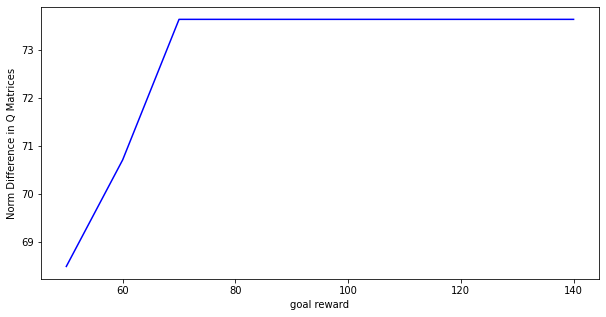

In [246]:
# visualize results
fig, ax = plt.subplots(1, 1, figsize=(10, 5)) # make a figure with one row and one column of size 10x5

ax.plot(reward_threshs, norms, color='blue')
ax.set_xlabel('goal reward')
ax.set_ylabel('Norm Difference in Q Matrices')
# ax.legend(loc='best')

plt.show() # display the figure

## 3. Generating Explanations
---

In [208]:
def generate_explanation(differences, user_policy_diff, new_policy_diff, new_user_return):
  # explanation
  for i, state in enumerate(differences):
    print("For State {}:".format(state))
    print("Instead of choosing from actions {}, our new policy suggests choosing from actions {} \n".format(user_policy_diff[i], new_policy_diff[i]))
  print("Doing so will result in an average episode length of {}".format(new_user_return))
  print("{} responses generated.".format(len(differences)))

In [210]:
new_user, new_user_return = sparse_Q_learner(user_agent, 80, penalty=5)
differences, user_policy_diff, new_policy_diff = compute_policy_difference(user_agent.Q, new_user.Q)
generate_explanation(differences, user_policy_diff, new_policy_diff, new_user_return)

Iteration 0
Episode 0 latest length 41
Episode 25 latest length 104
Evaluating Current New Policy
Evaluation episode 0: 33 steps
Evaluation episode 25: 64 steps
Evaluation episode 50: 70 steps
Evaluation episode 75: 129 steps
Current Return: 160.5
Iteration 1
Episode 0 latest length 179
Episode 25 latest length 227
Evaluating Current New Policy
Evaluation episode 0: 24 steps
Evaluation episode 25: 212 steps
Evaluation episode 50: 544 steps
Evaluation episode 75: 200 steps
Current Return: 96.0
Iteration 2
Episode 0 latest length 65
Episode 25 latest length 86
Evaluating Current New Policy
Evaluation episode 0: 428 steps
Evaluation episode 25: 66 steps
Evaluation episode 50: 72 steps
Evaluation episode 75: 100 steps
Current Return: 83.0
Iteration 3
Episode 0 latest length 69
Episode 25 latest length 74
Evaluating Current New Policy
Evaluation episode 0: 59 steps
Evaluation episode 25: 274 steps
Evaluation episode 50: 167 steps
Evaluation episode 75: 74 steps
Current Return: 81.0
Iteratio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


##**Experiments**
---

## Conjecture 1: "Bad" policies generate more counterfactuals
---
We first are given the optimal policy for a user. We then perturb their policy (disrupt their strategy) so that they become progressively worse as the number of perturbations increase. Our hypothesis is that as the nubmer of perturbations increase, so will the number of counterfactuals generated.

In [ ]:
# SEED EVERYTHING
# https://towardsdatascience.com/stop-using-numpy-random-seed-581a9972805f
RANDOM_SEED = 123
np.random.seed(RANDOM_SEED)
rl_env.seed(RANDOM_SEED)
rl_env.action_space.seed(RANDOM_SEED)

[123]

In [ ]:
# train the user extremely well, the policy should be optimal
user_agent = TaxiQLearner(rl_env)
user_agent.epsilon = 0.1 # We can adjust this to be lower if you want
train_data, train_rewards, train_lengths = user_agent.train(2000) 

Episode 0 latest length 626
Episode 50 latest length 136
Episode 100 latest length 6767
Episode 150 latest length 77
Episode 200 latest length 24
Episode 250 latest length 37
Episode 300 latest length 13
Episode 350 latest length 24
Episode 400 latest length 8
Episode 450 latest length 24
Episode 500 latest length 20
Episode 550 latest length 10
Episode 600 latest length 17
Episode 650 latest length 22
Episode 700 latest length 17
Episode 750 latest length 19
Episode 800 latest length 283
Episode 850 latest length 16
Episode 900 latest length 13
Episode 950 latest length 14
Episode 1000 latest length 17
Episode 1050 latest length 13
Episode 1100 latest length 205
Episode 1150 latest length 22
Episode 1200 latest length 24
Episode 1250 latest length 8
Episode 1300 latest length 15
Episode 1350 latest length 14
Episode 1400 latest length 19
Episode 1450 latest length 11
Episode 1500 latest length 15
Episode 1550 latest length 76
Episode 1600 latest length 35
Episode 1650 latest length 82

In [ ]:
def add_perturbation_to_matrix(Q, num_perturbs):
  perturbedQ = Q.copy()
  # re-setting random seed for reproducibility
  np.random.seed(2021)
  # random indices to pertrub
  idx = np.random.choice(range(len(Q)), num_perturbs)
  # we randomly selects states and then choose a random action to set to 1
  # the rest to 0
  j = Q.shape[1]
  for i in range(num_perturbs):
    perturbedQ[idx[i]] = np.zeros(j)
    # random action
    action_idx = np.random.choice(range(j))
    perturbedQ[idx[i]][action_idx] = 1

  return perturbedQ

In [ ]:
def run_perturbation_trial(optimal_Q, num_iters=200):
  num_counterfactuals = []
  # iterate through number of perturbations
  for i in range(50, num_iters, 20):
    perturbedQ = add_perturbation_to_matrix(optimal_Q, i)
    new_user, new_user_return, user_return = sparse_Q_learning(perturbedQ, max_iters=10, min_diff=20, percentage_diff=0.15, penalty=5)
    differences, user_policy_diff, new_policy_diff = compute_policy_difference(perturbedQ, new_user.Q)
    num_counterfactuals.append(len(differences))

  return num_counterfactuals

In [ ]:
output = run_perturbation_trial(user_agent.Q, 250)

Evaluation episode 0
Evaluation episode 100
Evaluation episode 200
Evaluation episode 300
Evaluation episode 400
Evaluation episode 0
Evaluation episode 100
Evaluation episode 200
Evaluation episode 300
Evaluation episode 400
Evaluation episode 0
Evaluation episode 100
Evaluation episode 200
Evaluation episode 300
Evaluation episode 400
0.922
Iteration:  0
Evaluation episode 0
Evaluation episode 100
Evaluation episode 200
Evaluation episode 300
Evaluation episode 400
0.898
Iteration:  1
Evaluation episode 0
Evaluation episode 100
Evaluation episode 200
Evaluation episode 300
Evaluation episode 400
0.916
Iteration:  2
Evaluation episode 0
Evaluation episode 100
Evaluation episode 200
Evaluation episode 300
Evaluation episode 400
0.89
Iteration:  3
Evaluation episode 0
Evaluation episode 100
Evaluation episode 200
Evaluation episode 300
Evaluation episode 400
0.872
Iteration:  4
Evaluation episode 0
Evaluation episode 100
Evaluation episode 200
Evaluation episode 300
Evaluation episode 4

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


Evaluation episode 100
Evaluation episode 200
Evaluation episode 300
Evaluation episode 400
Evaluation episode 0
Evaluation episode 100
Evaluation episode 200
Evaluation episode 300
Evaluation episode 400
Evaluation episode 0
Evaluation episode 100
Evaluation episode 200
Evaluation episode 300
Evaluation episode 400
0.93
Iteration:  0
Evaluation episode 0
Evaluation episode 100
Evaluation episode 200
Evaluation episode 300
Evaluation episode 400
0.912
Iteration:  1
Evaluation episode 0
Evaluation episode 100
Evaluation episode 200
Evaluation episode 300
Evaluation episode 400
0.934
Iteration:  2
Evaluation episode 0
Evaluation episode 100
Evaluation episode 200
Evaluation episode 300
Evaluation episode 400
0.916
Iteration:  3
Evaluation episode 0
Evaluation episode 100
Evaluation episode 200
Evaluation episode 300
Evaluation episode 400
0.898
Iteration:  4
Evaluation episode 0
Evaluation episode 100
Evaluation episode 200
Evaluation episode 300
Evaluation episode 400
0.94
Iteration:  5

KeyboardInterrupt: ignored

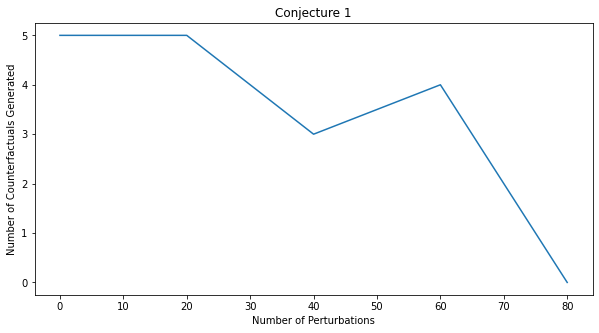

In [ ]:
# graph for conjecture 1
xs = range(0, 100, 20)

# plots
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.plot(xs, output)
ax.set_xlabel("Number of Perturbations")
ax.set_ylabel("Number of Counterfactuals Generated")
ax.set_title("Conjecture 1")

plt.show()

## Conjecture 2 [Sparsity]: Increasing the constant penalty term will result in sparser responses.
---

In [192]:
num_responses = []
penalties = [0, 0.2, 0.5, 1, 5]
for penalty in penalties:
  print("STARTING PENALTY", penalty)
  new_user = sparse_Q_learner(user_agent, 60, penalty)
  differences, user_policy_diff, new_policy_diff = compute_policy_difference(user_agent.Q, new_user.Q)
  num_responses.append(len(differences))

STARTING PENALTY 0
Iteration 0
Episode 0 latest length 3462
Episode 25 latest length 452
Evaluating Current New Policy
Evaluation episode 0: 188 steps
Evaluation episode 25: 42 steps
Evaluation episode 50: 230 steps
Evaluation episode 75: 35 steps
Current Return: 79.0
Iteration 1
Episode 0 latest length 763
Episode 25 latest length 24
Evaluating Current New Policy
Evaluation episode 0: 493 steps
Evaluation episode 25: 2235 steps
Evaluation episode 50: 50 steps
Evaluation episode 75: 54 steps
Current Return: 109.0
Iteration 2
Episode 0 latest length 50
Episode 25 latest length 22
Evaluating Current New Policy
Evaluation episode 0: 37 steps
Evaluation episode 25: 97 steps
Evaluation episode 50: 108 steps
Evaluation episode 75: 45 steps
Current Return: 54.5
User's Policy:  [array([0, 1, 2, 3, 4, 5]), array([4]), array([3]), array([4]), array([2]), array([0, 1, 2, 3, 4, 5]), array([0]), array([0]), array([0]), array([0]), array([0, 1, 2, 3, 4, 5]), array([0]), array([0]), array([3]), array

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


Episode 0 latest length 1271
Episode 25 latest length 1247
Evaluating Current New Policy
Evaluation episode 0: 655 steps
Evaluation episode 25: 62 steps
Evaluation episode 50: 24 steps
Evaluation episode 75: 14 steps
Current Return: 134.0
Iteration 1
Episode 0 latest length 585
Episode 25 latest length 1292
Evaluating Current New Policy
Evaluation episode 0: 110 steps
Evaluation episode 25: 2265 steps
Evaluation episode 50: 170 steps
Evaluation episode 75: 89 steps
Current Return: 101.0
Iteration 2
Episode 0 latest length 387
Episode 25 latest length 134
Evaluating Current New Policy
Evaluation episode 0: 105 steps
Evaluation episode 25: 470 steps
Evaluation episode 50: 85 steps
Evaluation episode 75: 12 steps
Current Return: 43.0
User's Policy:  [array([0, 1, 2, 3, 4, 5]), array([4]), array([3]), array([4]), array([2]), array([0, 1, 2, 3, 4, 5]), array([0]), array([0]), array([0]), array([0]), array([0, 1, 2, 3, 4, 5]), array([0]), array([0]), array([3]), array([0]), array([0, 1, 2, 3

In [193]:
print(num_responses)

[192, 165, 137, 120, 6]


## Conjecture 3 [User Preference]: Shaping the reward based on actionability of action $a$ from state $s$ will generate counterfactuals that align with higher weighted $(s, a)$ pairs.
---


In [ ]:
## TODO IN PROGRESS
# 6 actions: south, north, east, west, pickup passenger, dropoff passenger
# we assume that taxi user does not like taking left turns 
# so we downweight action 3
avoid_left_turns = lambda s, a: -10 if (a == 3) else -5

new_user, new_user_return, user_return = sparse_Q_learner(user_agent_Q, max_iters=20, min_diff=20, percentage_diff=0.15, penalty=avoid_left_turns)

In [ ]:
print(new_user_return)
print(user_return)
differences, user_policy_diff, new_policy_diff = compute_policy_difference(user_agent.Q, new_user.Q)
generate_explanation(differences, user_policy_diff, new_policy_diff, new_user_return, user_return)

0.722
0.694
User's Policy:  [array([0, 1, 2, 3, 4, 5]), array([4]), array([4]), array([4]), array([0]), array([0, 1, 2, 3, 4, 5]), array([0]), array([2]), array([0]), array([2]), array([0, 1, 2, 3, 4, 5]), array([2]), array([0]), array([3]), array([0]), array([0, 1, 2, 3, 4, 5]), array([5]), array([0]), array([0]), array([2]), array([0, 1, 2, 3, 4, 5]), array([3]), array([3]), array([3]), array([3]), array([0, 1, 2, 3, 4, 5]), array([3]), array([0]), array([3]), array([0]), array([0, 1, 2, 3, 4, 5]), array([0]), array([3]), array([2]), array([3]), array([0, 1, 2, 3, 4, 5]), array([3]), array([3]), array([3]), array([0]), array([0, 1, 2, 3, 4, 5]), array([0]), array([0]), array([0]), array([2]), array([0, 1, 2, 3, 4, 5]), array([2]), array([2]), array([2]), array([0]), array([0, 1, 2, 3, 4, 5]), array([2]), array([2]), array([2]), array([1]), array([0, 1, 2, 3, 4, 5]), array([0]), array([2]), array([2]), array([2]), array([0, 1, 2, 3, 4, 5]), array([0]), array([2]), array([2]), array([2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app
